In [1]:
import sys
import import_ipynb
from scipy.sparse.linalg import spsolve
from pathlib import Path
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as ma
    from fem_pos_processing import graph_results as gr
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 1: Poisson Problem at Rectangular Domain $\Omega = [0,1]^2$

Considere um problema de _Poisson_ 2D em $\Omega = [0,1]^2$

$$
-\nabla \cdot \left( \nabla u(x,y) \right) = f(x,y)
\tag{1}
$$

onde,
$$
f(x,y) = 2\pi^2 \, sin(\pi x) \, sin(\pi y)
\tag{2}
$$

cujas condições de contorno são $u=0$ em $\partial \Omega$.

A solução analítica deste problema é

$$
u(x,y) = sin(\pi x) \, sin(\pi y)
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos triangulares $P_1$ para resolver o Problema de Valor de Contorno $(1)$.

# 6-noded Quadratic Triangular Elements, $P_2$

In [2]:
FINITE_ELEMENT = ("Triangle", 2)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'omega'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]

# Create mesh from file geometry
mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=0.02, view_mesh=False)

Malha salva em pre_processing/mesh/rectangular_domain_Triangle2.msh
Model rectangular_domain (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 11849 nodes in total
Info     : 5824 2-D elements in total


## Figure 1: Rectangular meshed domain $\Omega=[0,1]^2$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pre_processing\pictures\meshed_domain_Triangle2_EntireDomain.svg


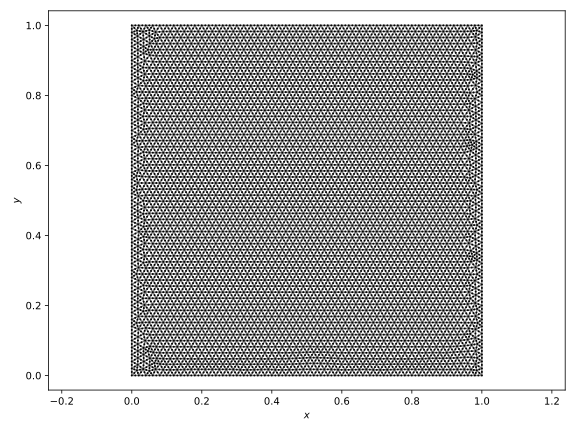

In [3]:
gr.plot_mesh(FINITE_ELEMENT, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle2_EntireDomain.svg"))

## Reduced Global matrix $A_{gr}$ with boundary conditions

In [4]:
Agr, fgr, Mgr, Pgr, Qgr = ma.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
uhr = spsolve(Agr.tocsr(), fgr.toarray())
uh = ma.global_potentials_solution(mesh_data, uhr)
print("Reduced global matrix shape:", Agr.shape)
print("Global Potencial Vector dimension:", len(uh))

Reduced global matrix shape: (11449, 11449)
Global Potencial Vector dimension: 11849


## Figure 2: Scalar Field Distribution on a Triangular Mesh

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p11_poisson_problem\pos_processing\pictures\fem_solution_Triangle2_EntireDomain.svg


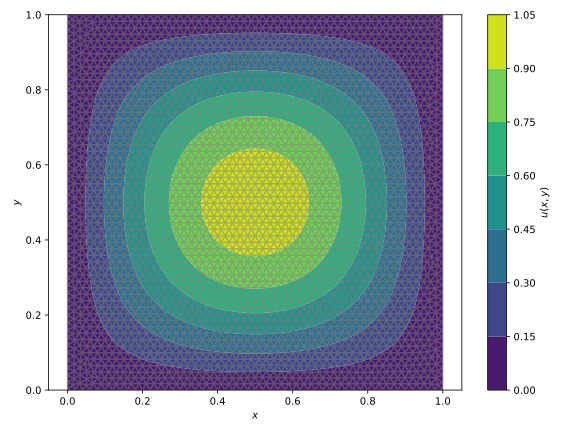

In [5]:
gr.fem_solution(FINITE_ELEMENT, mesh_data, uh)
display(SVG(filename="pos_processing/pictures/fem_solution_Triangle2.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.